In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm
from dataset import ChestXRayDataset
%matplotlib inline


In [ ]:
from CNN import create_model

classes = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

mlb = MultiLabelBinarizer(classes=classes)

NUM_CLASSES = 14
IMAGE_SIZE = 512 

model = create_model(num_classes=NUM_CLASSES)
model_path = "best_model.pth"  
model.load_state_dict(torch.load(model_path, map_location='mps'))

device = torch.device('mps')
model = model.to(device)

#evalution mode
model.eval()

print("Model loaded and set to evaluation mode")

/Users/ramosv/Desktop/GitHub/NIH-Chest-X-ray-Dataset/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramosv/Desktop/GitHub/NIH-Chest-X-ray-Dataset/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded and set to evaluation mode.


/var/folders/43/3wld4cld5ql99vlgz05r2c700000gn/T/ipykernel_97296/1089297825.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

In [ ]:
DATA_CSV = "Data/Data_Entry_2017_v2020.csv" 
IMAGES_DIR = "Data/images/" 

images = pd.read_csv(DATA_CSV)
images.columns = [
    "Image Index", "Finding Labels", "Follow-up #", "Patient ID",
    "Patient Age", "Patient Gender", "View Position",
    "OriginalImageWidth", "OriginalImageHeight",
    "OriginalImagePixelSpacing_x", "OriginalImagePixelSpacing_y"
]

images['Finding Labels'] = images['Finding Labels'].str.split('|')

mlb = MultiLabelBinarizer(classes=classes)
y = mlb.fit_transform(images['Finding Labels'])

train_patients, val_patients = train_test_split(
    images['Patient ID'].unique(),
    test_size=0.2,
    random_state=1  
)

train_df = images[images['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = images[images['Patient ID'].isin(val_patients)].reset_index(drop=True)

train_y = mlb.transform(train_df['Finding Labels'])
val_y = mlb.transform(val_df['Finding Labels'])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_dataset = ChestXRayDataset(val_df, val_y, IMAGES_DIR, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)  


print("Validation DataLoader is ready")


Validation DataLoader is ready.


/Users/ramosv/Desktop/GitHub/NIH-Chest-X-ray-Dataset/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['No Finding'] will be ignored
  warnings.warn(


In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Generating Predictions"):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        preds = outputs.cpu().numpy()
        true_labels = labels.cpu().numpy()
        
        all_preds.append(preds)
        all_labels.append(true_labels)

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

threshold = 0.5
all_preds_binary = (all_preds > threshold).astype(int)

print("Predictions generated.")


Generating Predictions: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]

Predictions generated.


In [ ]:
from sklearn.metrics import classification_report

accuracy = accuracy_score(all_labels, all_preds_binary)
precision = precision_score(all_labels, all_preds_binary, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds_binary, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds_binary, average='macro', zero_division=0)

print("=== Overall Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")

report = classification_report(all_labels, all_preds_binary, target_names=classes, zero_division=0)
print("\nClassification Report")
print(report)


=== Overall Evaluation Metrics ===
Accuracy: 0.5221
Precision (Macro): 0.1357
Recall (Macro): 0.0177
F1-Score (Macro): 0.0266

=== Classification Report ===
                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00        82
      Cardiomegaly       0.40      0.19      0.25        75
          Effusion       0.00      0.00      0.00       127
      Infiltration       0.00      0.00      0.00       153
              Mass       0.00      0.00      0.00        39
            Nodule       0.00      0.00      0.00        54
         Pneumonia       0.00      0.00      0.00        11
      Pneumothorax       0.00      0.00      0.00        18
     Consolidation       0.00      0.00      0.00        44
             Edema       0.50      0.03      0.06        34
         Emphysema       0.00      0.00      0.00        18
          Fibrosis       1.00      0.03      0.06        31
Pleural_Thickening       0.00      0.00      0.00        39
  

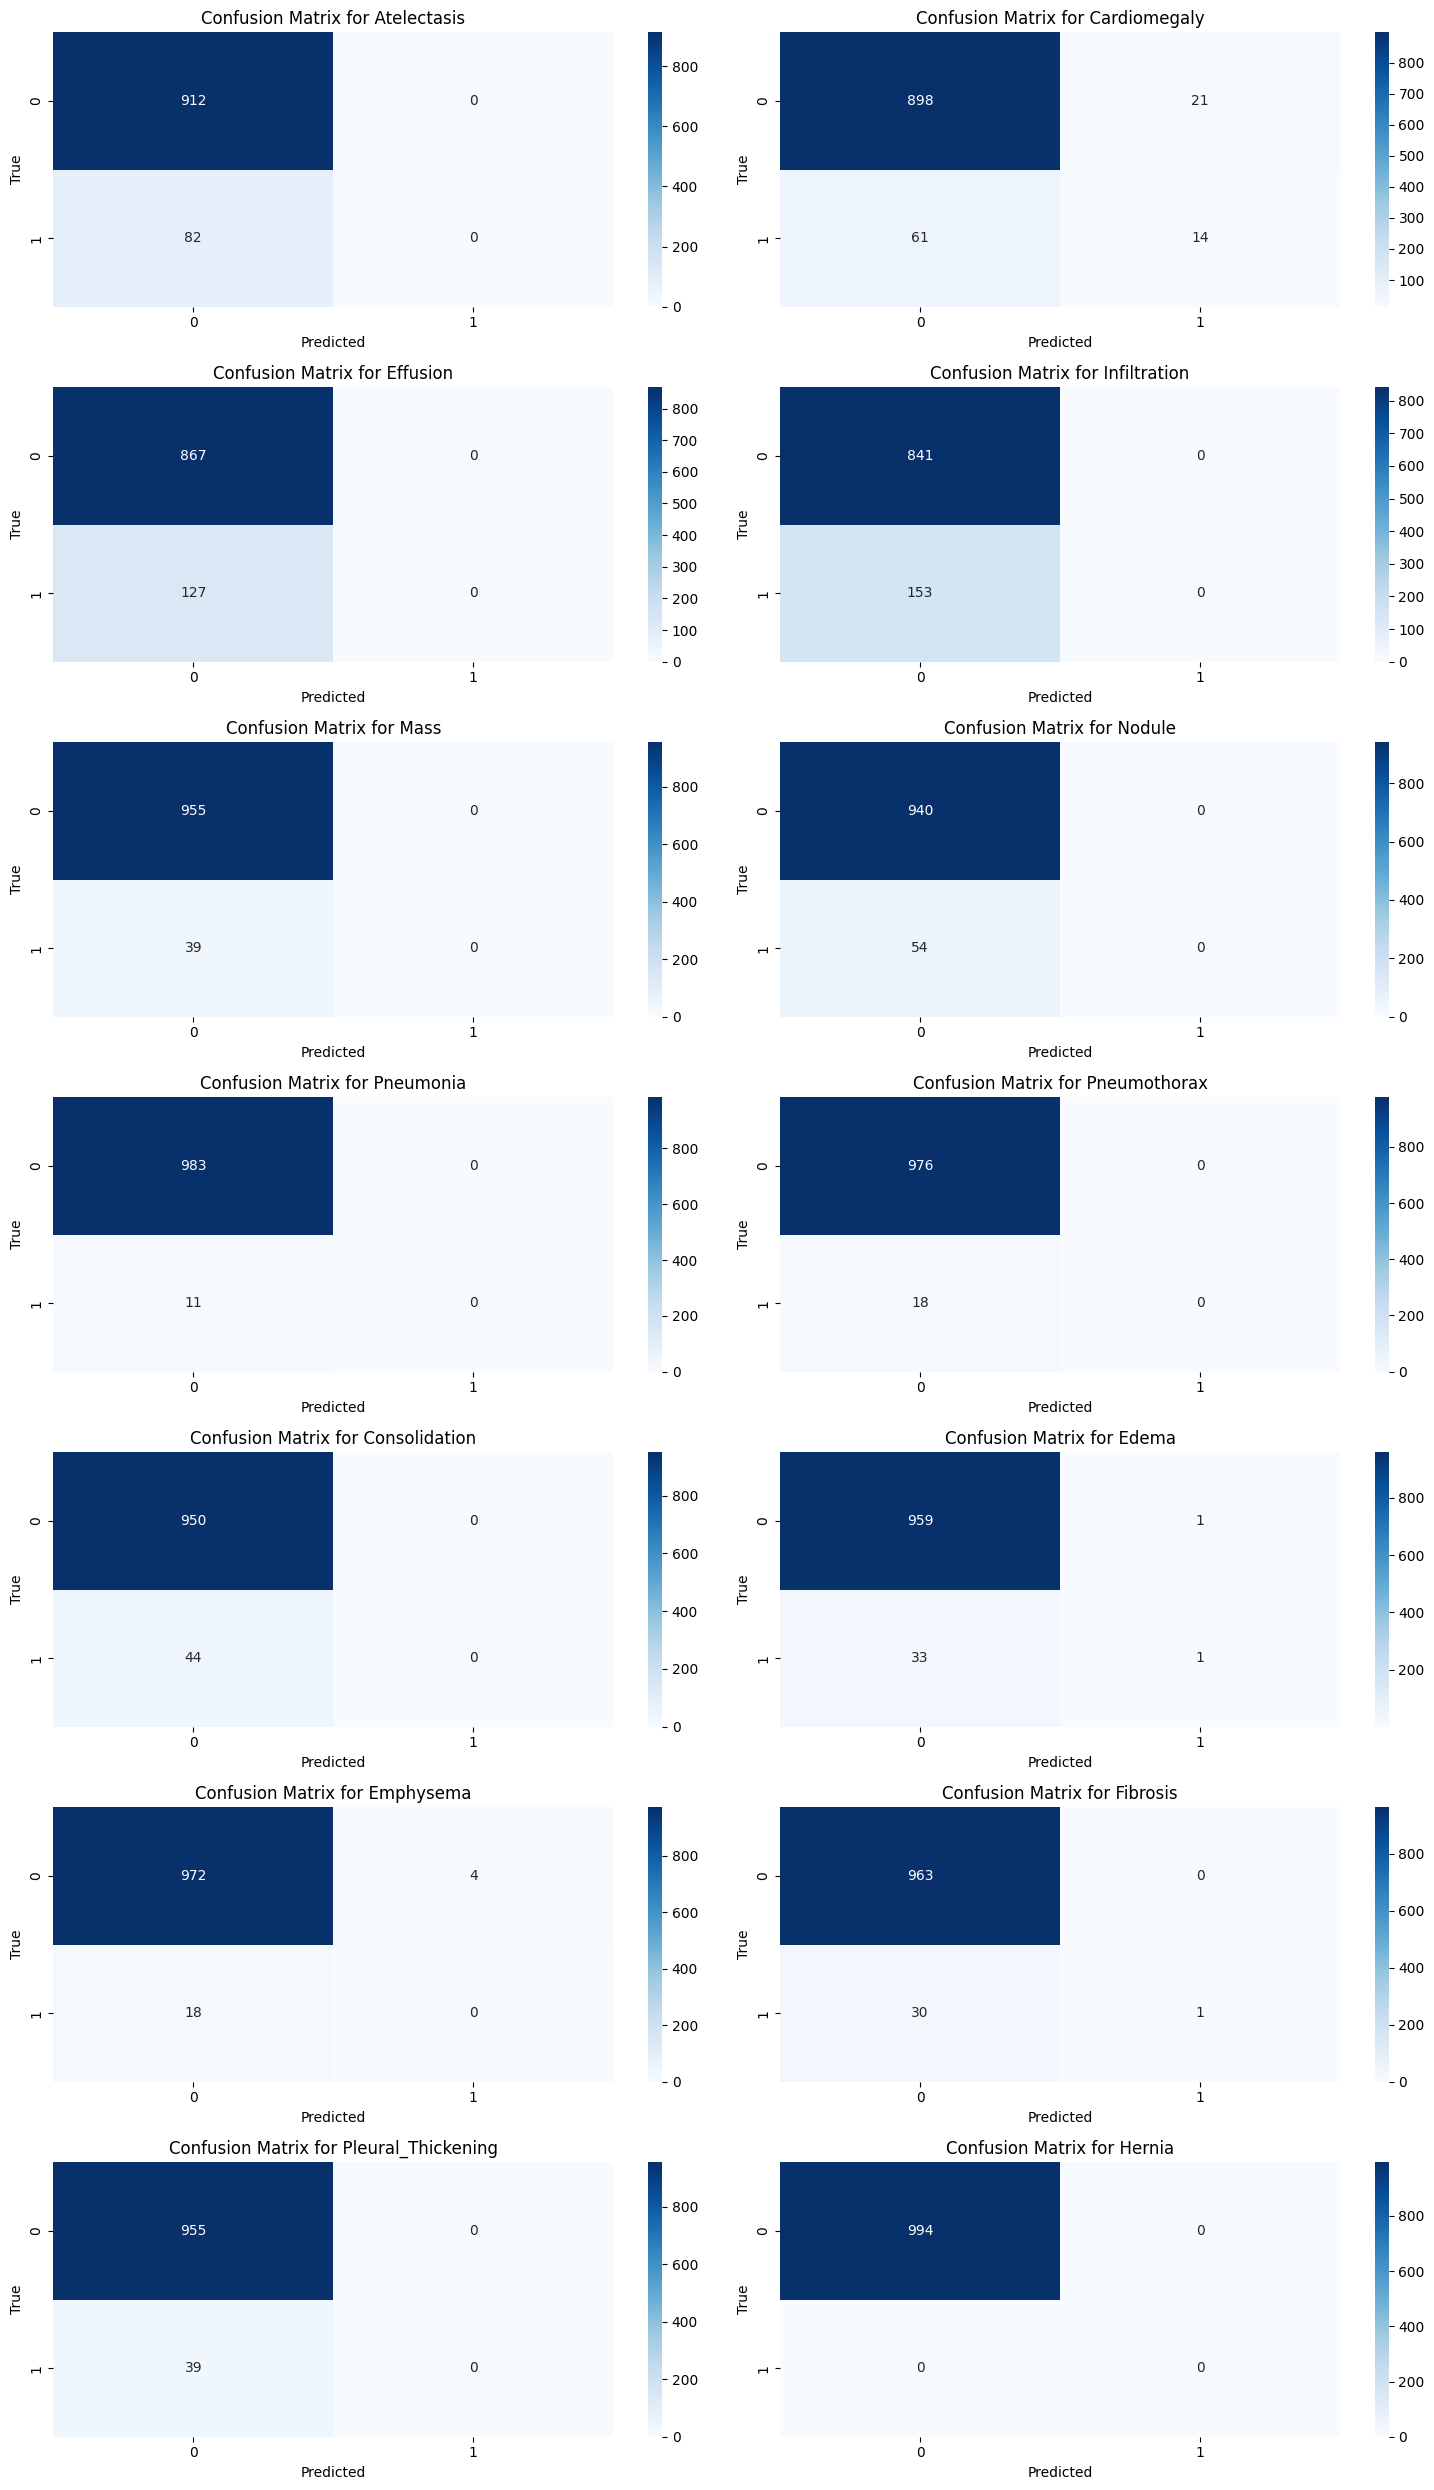

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(all_labels, all_preds_binary)

plt.figure(figsize=(15, 25))
for i, class_name in enumerate(classes):
    cm = mcm[i]
    plt.subplot(7, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()


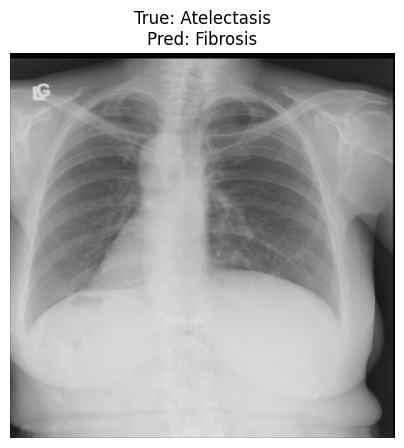

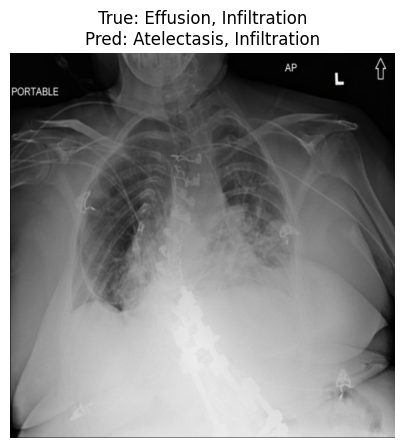

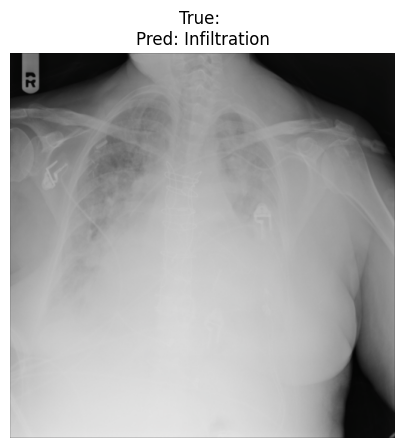

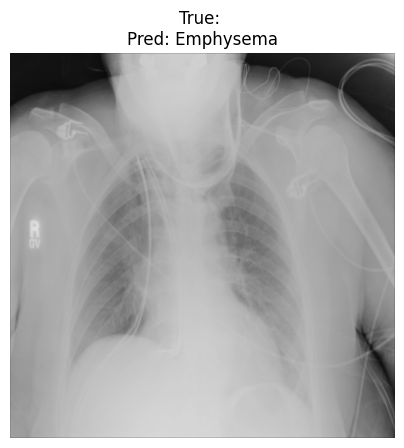

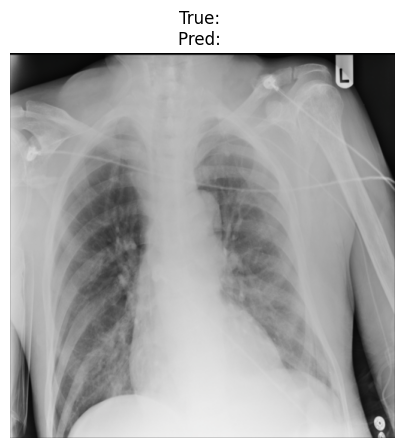

In [ ]:
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(len(val_dataset)), num_samples)

inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

for idx in indices:
    image, label = val_dataset[idx]
    
    inv_img = inv_normalize(image).permute(1,2,0).numpy().clip(0,1)
    
    plt.figure(figsize=(5,5))
    plt.imshow(inv_img)
    plt.axis('off')
    
    # Get true labels
    true_labels = [classes[i] for i, val in enumerate(label) if val == 1]
    
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(image_tensor).cpu().numpy().squeeze()
    pred_labels = [classes[i] for i, val in enumerate(pred > 0.3) if val]
    
    plt.title(f"True: {', '.join(true_labels)}\nPred: {', '.join(pred_labels)}")
    plt.show()
